### Scratch notebook for processing Project Gutenberg texts

In [1]:
import os
from glob import glob
import requests

In [2]:
curdir = os.path.abspath(os.curdir)
print(curdir)

C:\Users\ARADER\Documents\presentations\tutorials\nlp\notebooks


In [4]:
os.chdir('../data')

In [6]:
current_textfile_listing = glob('*.txt')

### define a function to download a book by id

In [7]:
def load_gutenberg_text(book_id, file_format='txt',search_path=None):
    file_found_flag = False
    # look locally
    if search_path is None:
        search_path = os.path.abspath(os.curdir)
    file_end='*'+file_format
    dl_files = glob(os.path.join(search_path,file_end))
    #print(dl_files)
    book_id_str = str(book_id)
    possible_match = [fname for fname in dl_files if fname.split('\\')[-1].startswith(book_id_str)]
    if possible_match:
        for m in possible_match:
            match_file = m.split('\\')[-1]
            if match_file.rstrip('.txt').split('-')[0]==book_id_str:
                #print(match_file)
                file_found_flag = True
                read_file = open(m,'br')
                text = read_file.read()
                read_file.close()
                print(match_file, " found")
                return text.decode('utf-8')
    
    # now look to download   
    key_files = [str(book_id)+'.'+file_format, str(book_id)+'-0.'+file_format ]
    
    kf_idx = 0
    #while not file_found_flag:
    for kf in key_files:
        dl_file_url = 'https://www.gutenberg.org/files/'+str(book_id)+'/'+kf
        print(dl_file_url)
        resp = requests.get(dl_file_url)
        if resp.status_code == 200:
            f = open(kf,'bw')
            f.write(resp.content)
            f.close()
            text=resp.content
            file_found_flag=True
            return text.decode('utf-8')
        else:
            print(resp.status_code)
            #kf_idx+=1
            #print(key_files[kf_idx])
            
    #return None
    
        
    

    

In [8]:

[fn for fn in current_textfile_listing if fn.startswith('48320')]

['48320-0.txt']

In [9]:
r0 =load_gutenberg_text(48320)

48320-0.txt  found


In [10]:
len(r0)

608162

## Trying to make functions that clean this up
_and testing these_, empirically

In [14]:
def cleanup_PG_text(raw_text):
    # first id the title & author
    tmp = [a.strip('\r') for a in raw_text.split('\n')]
    print(len(tmp))
    lines_to_find = ['*** START OF THIS PROJECT GUTENBERG EBOOK', '*** END OF THIS PROJECT GUTENBERG EBOOK']
    ll_to_find = [line for line in tmp if line.startswith(lines_to_find[0]) or line.startswith(lines_to_find[1])]
    last_index = next(i for i,v in zip(range(len(tmp)-1,-1,-1), reversed(tmp)) if v == 'THE END')
    title_str = ll_to_find[0].split('EBOOK')[-1].rstrip('***').strip(' ')
    title_idx = [(line,k) for k,line in enumerate(tmp) if line.startswith(title_str)]
    title_index = max(title_idx) 
    return tmp[title_index:last_index]
    

In [17]:
tmp = [a.strip('\r') for a in r0.split('\n')]
ll = [line for line in tmp if line.startswith('*** ')]
ll

['*** START OF THIS PROJECT GUTENBERG EBOOK ADVENTURES OF SHERLOCK HOLMES ***',
 '*** END OF THIS PROJECT GUTENBERG EBOOK ADVENTURES OF SHERLOCK HOLMES ***',
 '*** START: FULL LICENSE ***']

In [46]:
ll

['*** START OF THIS PROJECT GUTENBERG EBOOK ADVENTURES OF SHERLOCK HOLMES ***',
 '*** END OF THIS PROJECT GUTENBERG EBOOK ADVENTURES OF SHERLOCK HOLMES ***',
 '*** START: FULL LICENSE ***']

In [18]:
tmp.index(ll[1])-309

12087

In [19]:
tmp2 = tmp[145:12087]
len(tmp2)

11942

In [20]:
[line for line in tmp2 if 'Adventure' in line ]

['Adventure I',
 'Adventure II',
 'Adventure III',
 'Adventure IV',
 'Adventure V',
 'Adventure VI',
 'Adventure VII',
 'Adventure VIII',
 'Adventure IX',
 'Adventure X',
 'Adventure XI',
 'Adventure XII']

In [65]:
title_str=ll[0].split('EBOOK')[-1].rstrip('***').strip(' ')
tmp.index(title_str)

37

In [67]:
tmp.index(ll[0])

19

In [22]:
def parse_sherlock_holmes(text, key_word='Adventure '):
    chapter_idx = [k for k,line in enumerate(text) if key_word in line ]
    print(len(chapter_idx))
    chapters=[] 
    for i,a in enumerate(chapter_idx):
        if i != len(chapter_idx)-1:
            b = chapter_idx[i+1]-1
        else: 
            b = len(text)
        chapter_name = text[a]
        chapter_title = text[a+2]
        chapter_text = ' '.join([line for line in text[a+3:b] if not line.startswith("[Illustration:")])
        chapter_meta = {}
        chapter_meta['name']=chapter_name
        chapter_meta['title']=chapter_title
        chapter_meta['text']=chapter_text
        chapters.append(chapter_meta)
    #print([(a,text[a]) for a in chapter_idx])
    
    
    return chapters
    

In [23]:
chapter_idx = [k for k,line in enumerate(tmp2) if 'Adventure ' in line ]
chapter_idx

[2, 1083, 2130, 2885, 3944, 4783, 5831, 6758, 7904, 8818, 9795, 10862]

In [24]:
len(chapter_idx)

12

In [25]:
tmp2[1086:1090]

['',
 '',
 'I had called upon my friend, Mr. Sherlock Holmes, one day in the autumn',
 'of last year, and found him in deep conversation with a very stout,']

In [26]:
chapters = parse_sherlock_holmes(tmp2)

12


In [27]:
all_in_one_corpus = " ".join([c['text'] for c in chapters])

In [28]:

for c in chapters:
    print(c['title'], len(c['text']))

A SCANDAL IN BOHEMIA 46521
THE RED-HEADED LEAGUE 49380
A CASE OF IDENTITY 37962
THE BOSCOMBE VALLEY MYSTERY 51421
THE FIVE ORANGE PIPS 39520
THE MAN WITH THE TWISTED LIP 49231
THE ADVENTURE OF THE BLUE CARBUNCLE 42138
THE ADVENTURE OF THE SPECKLED BAND 53111
THE ADVENTURE OF THE ENGINEER’S THUMB 44623
THE ADVENTURE OF THE NOBLE BACHELOR 44172
THE ADVENTURE OF THE BERYL CORONET 51021
THE ADVENTURE OF THE COPPER BEECHES 53255


In [29]:
from nltk.tokenize import word_tokenize
tokens = word_tokenize(c['text'])
print(tokens)

['“', 'To', 'the', 'man', 'who', 'loves', 'art', 'for', 'its', 'own', 'sake', ',', '”', 'remarked', 'Sherlock', 'Holmes', ',', 'tossing', 'aside', 'the', 'advertisement', 'sheet', 'of', '_The', 'Daily', 'Telegraph_', ',', '“', 'it', 'is', 'frequently', 'in', 'its', 'least', 'important', 'and', 'lowliest', 'manifestations', 'that', 'the', 'keenest', 'pleasure', 'is', 'to', 'be', 'derived', '.', 'It', 'is', 'pleasant', 'to', 'me', 'to', 'observe', ',', 'Watson', ',', 'that', 'you', 'have', 'so', 'far', 'grasped', 'this', 'truth', 'that', 'in', 'these', 'little', 'records', 'of', 'our', 'cases', 'which', 'you', 'have', 'been', 'good', 'enough', 'to', 'draw', 'up', ',', 'and', ',', 'I', 'am', 'bound', 'to', 'say', ',', 'occasionally', 'to', 'embellish', ',', 'you', 'have', 'given', 'prominence', 'not', 'so', 'much', 'to', 'the', 'many', '_causes', 'célèbres_', 'and', 'sensational', 'trials', 'in', 'which', 'I', 'have', 'figured', ',', 'but', 'rather', 'to', 'those', 'incidents', 'which', '

## tokenize and count

In [30]:
from nltk.tokenize import word_tokenize

try:  # py3
    all_tokens = [t for t in word_tokenize(all_in_one_corpus)]
except UnicodeDecodeError:  # py27
    all_tokens = [t for t in word_tokenize(all_in_one_corpus.decode('utf-8'))]

print("Total number of tokens: {}".format(len(all_tokens)))

Total number of tokens: 125668


In [31]:
from collections import Counter

total_term_frequency = Counter(all_tokens)

for word, freq in total_term_frequency.most_common(20):
    print("{}\t{}".format(word, freq))

,	8311
the	5238
.	4379
I	3025
and	2797
“	2759
to	2650
of	2612
a	2514
”	2332
in	1680
that	1641
was	1388
it	1245
you	1189
he	1164
his	1101
is	1099
’	1052
my	906


In [32]:
import en_core_web_sm as spacy_en
nlp = spacy_en.load()

In [33]:
doc = nlp(u"This is a sentence.")
print([(w.text, w.pos_ ) for w in doc])

[('This', 'DET'), ('is', 'VERB'), ('a', 'DET'), ('sentence', 'NOUN'), ('.', 'PUNCT')]


In [34]:
for token in doc:
    print(token.text)

This
is
a
sentence
.


In [35]:
d2 = nlp(all_in_one_corpus)

In [36]:
len(d2)

130383

In [37]:
d2[5].vector_norm, d2[4].vector_norm

(23.328333, 26.321907)

In [38]:
d2[4].similarity(d2[5])

0.46891278

In [40]:
for token in d2[:10000]:
    
    if token.text == 'Sherlock':
        print(token.text,token.has_vector, token.pos_, token.tag_)
        for token2 in d2[:10000]:
            #if token.pos_ in 
            s = token2.similarity(token)
            if s > .5:
                print(token2.text, token2.pos_, token2.tag_)

Sherlock True PROPN NNP
Sherlock PROPN NNP
Irene PROPN NNP
Adler PROPN NNP
Street PROPN NNP
Odessa PROPN NNP
Atkinson PROPN NNP
March PROPN NNP
Street PROPN NNP
Study PROPN NNP
Scarlet PROPN NNP
Mary PROPN NNP
Jane PROPN NNP
Peculiar PROPN NNP
Eglow PROPN NNP
Bohemia PROPN NNP
Wallenstein PROPN NNP
Bohemia PROPN NNP
England PROPN NNP
Dr. PROPN NNP
Count PROPN NNP
Von PROPN NNP
Ormstein PROPN NNP
Europe PROPN NNP
Gottsreich PROPN NNP
Sigismond PROPN NNP
Ormstein PROPN NNP
Grand PROPN NNP
Cassel PROPN NNP
Bohemia PROPN NNP
Prague PROPN NNP
Warsaw PROPN NNP
Irene PROPN NNP
Jersey PROPN NNP
Scala PROPN NNP
Warsaw PROPN NNP
Crown PROPN NNP
Prince PROPN NNP
  SPACE 
King PROPN NNP
Clotilde PROPN NNP
Lothman PROPN NNP
Saxe PROPN NNP
King PROPN NNP
Irene PROPN NNP
Adler PROPN NNP
Count PROPN NNP
Von PROPN NNP
  SPACE 
Lodge PROPN NNP
Serpentine PROPN NNP
Avenue PROPN NNP
St. PROPN NNP
John PROPN NNP
Wood PROPN NNP
  SPACE 
Street PROPN NNP
Miss PROPN NNP
Irene PROPN NNP
Lodge PROPN NNP
Irene P

In [41]:
tag_counts = Counter()
pos_counts = Counter()
for token in d2:
    tag_counts[token.tag_]+=1
    pos_counts[token.pos_]+=1
len(tag_counts.keys()), len(pos_counts.keys())


(51, 16)

In [42]:
pos_counts

Counter({'ADJ': 10994,
         'ADP': 14017,
         'ADV': 8035,
         'CCONJ': 3962,
         'DET': 10663,
         'INTJ': 484,
         'NOUN': 18197,
         'NUM': 940,
         'PART': 2564,
         'PRON': 10713,
         'PROPN': 3819,
         'PUNCT': 21544,
         'SPACE': 2648,
         'SYM': 37,
         'VERB': 21751,
         'X': 15})

In [43]:
for token in d2:
    if token.pos_ in ['X','SYM']:
        print(token.pos_,token.text)

X devil,’
SYM £
SYM £
X nominal.’
SYM £
SYM £
SYM £
X de
SYM £
SYM -
SYM £
X etc
X etc
SYM £
SYM £
SYM £
SYM £
SYM £
SYM £
SYM £
SYM £
SYM £
SYM £
SYM £
SYM £
SYM £
SYM £
SYM £
X wait,’
X well,’
X etc
X etc
X accompli
X de
X foie
X pa
SYM £
SYM £
SYM £
X matters.’
SYM £
SYM £
SYM £
SYM £
SYM £
SYM £
X hair?’
SYM £
SYM £
SYM £
SYM £
SYM £


In [44]:
## restrict to words:
d3 = [token for token in d2 if token.pos_ not in ['X','SYM','SPACE','PUNCT']]
len(d3)

106139

## now count these words

In [45]:
all_terms = [token.norm_ for token in d3]
total_term_frequency = Counter(all_terms)

In [46]:
for word, freq in total_term_frequency.most_common(20):
    print("{}\t{}".format(word, freq))

the	5597
and	3016
i	3008
to	2740
of	2641
gonna	2530
have	1769
in	1765
that	1752
it	1725
you	1489
he	1482
was	1410
his	1159
is	1126
my	1007
as	852
with	828
not	779
which	772


(array([8.109e+03, 4.500e+01, 1.700e+01, 1.900e+01, 8.000e+00, 3.000e+00,
        4.000e+00, 2.000e+00, 1.000e+00, 0.000e+00, 2.000e+00, 0.000e+00,
        1.000e+00, 2.000e+00, 0.000e+00, 4.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 1.000e+00,
        1.000e+00, 0.000e+00, 2.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00]),
 array([1.00000e+00, 1.12920e+02, 2.24840e+02, 3.36760e+02, 4.48680e+02,
        5.60600e+02, 6.72520e+02, 7.84440e+02, 8.96360e+02, 1.00828e+03,
        1.12020e+03, 1.23212e+03, 1.34404e+03, 1.45596e+03, 1.56788e+03,
        1.67980e+03, 1.79172e+03, 1.90364e+03, 2.01556e+03, 2.12748e+03,
        2.23940e+03, 2.35132e+03, 2.46324e+03, 2.57516e+03, 2.68708e+03,
        2.7

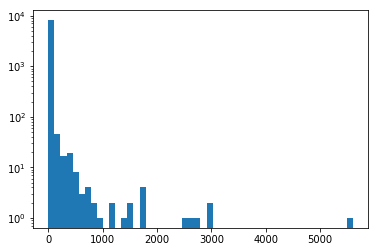

In [47]:
%matplotlib inline
from matplotlib import pyplot as plt
plt.hist(total_term_frequency.values(),bins=50,log=True)

(array([3.871e+03, 0.000e+00, 1.263e+03, 6.710e+02, 3.980e+02, 2.940e+02,
        4.050e+02, 2.260e+02, 2.870e+02, 1.650e+02, 1.610e+02, 1.240e+02,
        7.700e+01, 6.100e+01, 4.800e+01, 4.600e+01, 2.500e+01, 2.300e+01,
        1.300e+01, 1.100e+01, 1.600e+01, 1.300e+01, 4.000e+00, 5.000e+00,
        3.000e+00, 7.000e+00, 0.000e+00, 5.000e+00, 0.000e+00, 1.000e+00]),
 array([0.        , 0.2876662 , 0.5753324 , 0.8629986 , 1.1506648 ,
        1.438331  , 1.7259972 , 2.0136634 , 2.30132961, 2.58899581,
        2.87666201, 3.16432821, 3.45199441, 3.73966061, 4.02732681,
        4.31499301, 4.60265921, 4.89032541, 5.17799161, 5.46565781,
        5.75332401, 6.04099021, 6.32865641, 6.61632261, 6.90398882,
        7.19165502, 7.47932122, 7.76698742, 8.05465362, 8.34231982,
        8.62998602]),
 <a list of 30 Patch objects>)

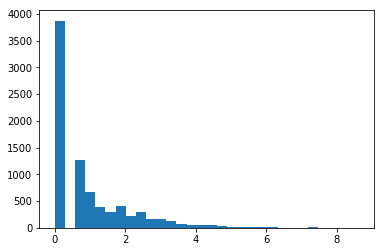

In [48]:
import numpy as np
plt.hist([np.log(x) for x in total_term_frequency.values()],bins=30)

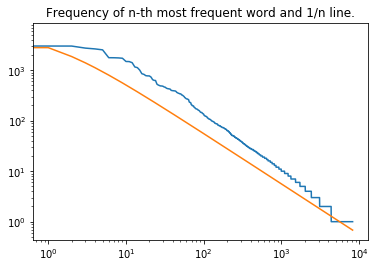

In [49]:
M = total_term_frequency['the']
plt.yscale('log'); plt.xscale('log'); plt.title('Frequency of n-th most frequent word and 1/n line.')
plt.plot([c for (w, c) in total_term_frequency.most_common()])
plt.plot([M/i for i in range(1, len(total_term_frequency)+1)]);

In [50]:
len(total_term_frequency.keys())

8223

## now explore how many documents each word is in

In [51]:
document_frequency = Counter()
for chapt in chapters:
    raw_chapt_tokens = nlp(chapt['text'])
    chapt_tokens = [token for token in raw_chapt_tokens if token.pos_ not in ['X','SYM','SPACE','PUNCT']]
    chapt_words = [token.norm_ for token in chapt_tokens]
    document_frequency.update(chapt_words)
    
for word,freq in document_frequency.most_common(20):
    print("{w}\t{f}".format(w=word,f=freq))

the	5597
and	3016
i	3008
to	2740
of	2641
gonna	2530
have	1769
in	1765
that	1752
it	1725
you	1489
he	1482
was	1410
his	1159
is	1126
my	1007
as	852
with	828
not	779
which	772


In [52]:
total_term_frequency.most_common(20)


[('the', 5597),
 ('and', 3016),
 ('i', 3008),
 ('to', 2740),
 ('of', 2641),
 ('gonna', 2530),
 ('have', 1769),
 ('in', 1765),
 ('that', 1752),
 ('it', 1725),
 ('you', 1489),
 ('he', 1482),
 ('was', 1410),
 ('his', 1159),
 ('is', 1126),
 ('my', 1007),
 ('as', 852),
 ('with', 828),
 ('not', 779),
 ('which', 772)]

In [53]:
[(d.text, d.norm_, d.pos_, d.is_stop) for d in d2[:30]]

[('  ', '  ', 'SPACE', False),
 ('I', 'i', 'PRON', False),
 (' ', ' ', 'SPACE', False),
 ('To', 'to', 'ADP', False),
 ('Sherlock', 'sherlock', 'PROPN', False),
 ('Holmes', 'holmes', 'PROPN', False),
 ('she', 'she', 'PRON', True),
 ('is', 'is', 'VERB', True),
 ('always', 'always', 'ADV', True),
 ('_', '_', 'VERB', False),
 ('the', 'the', 'DET', True),
 ('_', '_', 'ADJ', False),
 ('woman', 'woman', 'NOUN', False),
 ('.', '.', 'PUNCT', False),
 ('I', 'i', 'PRON', False),
 ('have', 'have', 'VERB', True),
 ('seldom', 'seldom', 'ADV', False),
 ('heard', 'heard', 'VERB', False),
 ('him', 'him', 'PRON', True),
 ('mention', 'mention', 'VERB', False),
 ('her', 'her', 'PRON', True),
 ('under', 'under', 'ADP', True),
 ('any', 'any', 'DET', True),
 ('other', 'other', 'ADJ', True),
 ('name', 'name', 'NOUN', True),
 ('.', '.', 'PUNCT', False),
 ('In', 'in', 'ADP', False),
 ('his', 'his', 'ADJ', True),
 ('eyes', 'eyes', 'NOUN', False),
 ('she', 'she', 'PRON', True)]

## use nltk stopwords

In [55]:
import nltk
stop_words = set(nltk.corpus.stopwords.words('english'))

In [56]:
d4 = [token for token in d3 if token.norm_ not in stop_words ]
len(d4), len(d3)

(50572, 106139)

In [57]:
no_stop_terms = [token.norm_ for token in d4]
no_stop_term_frequency = Counter(no_stop_terms)
no_stop_term_frequency.most_common(20)

[('gonna', 2530),
 ('said', 487),
 ('upon', 465),
 ('holmes', 460),
 ('one', 422),
 ("'s", 363),
 ('would', 341),
 ('man', 300),
 ('could', 287),
 ('little', 269),
 ('mr.', 269),
 ('see', 228),
 ('may', 197),
 ('well', 196),
 ('a.m.', 185),
 ('us', 182),
 ('room', 173),
 ('think', 172),
 ('shall', 170),
 ('know', 169)]

In [58]:
from nltk import ngrams

In [59]:
phrases = Counter(ngrams(no_stop_terms, 2))
for phrase, freq in phrases.most_common(20):
    print("{p}\t{f}".format(p=phrase,f=freq))

('said', 'holmes')	112
('gonna', 'little')	96
('sherlock', 'holmes')	95
('gonna', 'man')	79
('mr.', 'holmes')	70
('gonna', 'small')	45
('st.', 'simon')	39
('could', 'see')	31
('gonna', 'long')	30
('gonna', 'good')	30
('like', 'gonna')	29
('baker', 'street')	28
('lord', 'st.')	28
('gonna', 'woman')	27
('st.', 'clair')	27
('upon', 'gonna')	25
('man', 'gonna')	25
('gonna', 'large')	24
('let', 'us')	21
('a.m.', 'sure')	21


## Get more texts

In [60]:
#baskervilles_id =2852
holmes_return_id = 221
verne_eightydays_id = 103
verne_undersea_id = 2488
austen_emma_id  =158
austen_pp_id = 1342

In [61]:
%pwd

'C:\\Users\\ARADER\\Documents\\presentations\\tutorials\\nlp\\data'

In [62]:
h2 = load_gutenberg_text(holmes_return_id)

221-0.txt  found


In [63]:
aust0 = load_gutenberg_text(austen_emma_id)
aust1  = load_gutenberg_text(austen_pp_id)

158-0.txt  found
1342-0.txt  found


In [64]:
def load_pg_text(my_file):
    try:
        with open(my_file,'rb') as f:
            text=f.read()
            raw_text=text.decode('utf-8')
    except UnicodeDecodeError:
        with open(my_file) as f:
            raw_text=f.read()
            
    # first id the title & author
    tmp = [a.strip('\r') for a in raw_text.split('\n')]
    lines_to_find = ['*** START OF THIS PROJECT GUTENBERG EBOOK', '*** END OF THIS PROJECT GUTENBERG EBOOK']
    ll_to_find = [line for line in tmp if line.startswith(lines_to_find[0]) or line.startswith(lines_to_find[1])]
    try:
        start_idx = tmp.index(ll_to_find[0])
        end_idx = tmp.index(ll_to_find[1])
        title_str = ll_to_find[0].split('EBOOK')[-1].rstrip('***').strip(' ')
        if title_str == 'AROUND THE WORLD IN 80 DAYS':
            title_str=title_str.replace('80','EIGHTY')
        title_idx = [k for k,line in enumerate(tmp) if line.startswith(title_str)]
        title_index = max(title_idx) 
        
    except IndexError:
        start_idx = [k for k, line in enumerate(tmp) if line.startswith('*END THE SMALL PRINT!')][0]
        end_idx = [k for k,line in enumerate(tmp) if line.startswith('End of the Project Gutenberg Etext')][-1]-1
        #title_str=" ".join([a for a in tmp[7:12] if a != ""])
        title_index = start_idx    
   
    try:
        last_index = next(i for i,v in zip(range(len(tmp)-1,-1,-1), reversed(tmp)) if 'THE END' in v)
    except StopIteration:
        last_index = len(tmp)-2
        
    return tmp[title_index:last_index]

In [65]:
book_files = glob('*.txt')
book_files

['103.txt',
 '1342-0.txt',
 '158-0.txt',
 '21839.txt',
 '221-0.txt',
 '2488.txt',
 '28139.txt',
 '2852.txt',
 '3748.txt',
 '48320-0.txt']

In [66]:
pg_text =[]
for bf in book_files:
    pg_text.append(load_pg_text(bf))

ValueError: max() arg is an empty sequence

In [67]:
class Chapter(object):
    """A class to contain chapters from Project Gutenberg text files"""
    def __init__(self, name, title, text, author, book_id, chapter_index):
        self.name=name
        self.title=title
        self.text=text
        self.author=author
        self.book_id=book_id
        self.chapter_index=chapter_index
        
    
def split_into_chapters(text, book_id, key_word='Adventure ', authorname=None):
    #def parse_sherlock_holmes(text, key_word='Adventure '):
    if authorname is None:
        authorname = 'unknown'
    chapter_idx = [k for k,line in enumerate(text) if key_word in line ]
    #print(len(chapter_idx))
    if key_word == 'THE STRAND MAGAZINE':
        chapter_idx = [c+6 for c in chapter_idx]
        
    chapters=[] 
    for i,a in enumerate(chapter_idx):
        if i != len(chapter_idx)-1:
            b = chapter_idx[i+1]-1
        else: 
            b = len(text)
            
        chapter_name = text[a]
        chapter_title = text[a+2] #TOD improve this
        chapter_text = ' '.join([line for line in text[a+3:b] if not line.startswith("[Illustration:")]) #drop illustration lines
        my_chapter = Chapter(chapter_name, chapter_title, chapter_text, authorname, book_id, i)
        #chapter_meta = {}
        #chapter_meta['name']=chapter_name
        #chapter_meta['title']=chapter_title
        #chapter_meta['text']=chapter_text
        chapters.append(my_chapter)
        
    return chapters


In [68]:
pg_text[0][26:35]

['         AIDS TO dETECTIVES',
 '',
 '   VIII  IN WHICH PASSEPARTOUT TALKS RATHER MORE, PERHAPS, THAN IS PRUDENT',
 '',
 '     IX  IN WHICH THE RED SEA AND THE INDIAN OCEAN PROVE PROPITIOUS',
 '         TO THE DESIGNS OF PHILEAS FOGG',
 '',
 '      X  IN WHICH PASSEPARTOUT IS ONLY TOO GLAD TO GET OFF WITH THE LOSS',
 '         OF HIS SHOES']

In [69]:
cc0 = split_into_chapters(pg_text[0],'103',key_word='Chapter ', authorname='Verne')


In [70]:
cc0[0].text

'THE ONE AS MASTER, THE OTHER AS MAN   Mr. Phileas Fogg lived, in 1872, at No. 7, Saville Row, Burlington Gardens, the house in which Sheridan died in 1814.  He was one of the most noticeable members of the Reform Club, though he seemed always to avoid attracting attention; an enigmatical personage, about whom little was known, except that he was a polished man of the world.  People said that he resembled Byron--at least that his head was Byronic; but he was a bearded, tranquil Byron, who might live on a thousand years without growing old.  Certainly an Englishman, it was more doubtful whether Phileas Fogg was a Londoner.  He was never seen on \'Change, nor at the Bank, nor in the counting-rooms of the "City"; no ships ever came into London docks of which he was the owner; he had no public employment; he had never been entered at any of the Inns of Court, either at the Temple, or Lincoln\'s Inn, or Gray\'s Inn; nor had his voice ever resounded in the Court of Chancery, or in the Excheq

In [71]:
book_files[4]

'221-0.txt'

In [73]:
cc0[2].book_id, cc0[2].author, cc0[2].title, cc0[2].name

('103',
 'Verne',
 'IN WHICH A CONVERSATION TAKES PLACE WHICH SEEMS LIKELY TO COST PHILEAS',
 'Chapter III')

In [74]:
cc0[7].text

'  Fix soon rejoined Passepartout, who was lounging and looking about on the quay, as if he did not feel that he, at least, was obliged not to see anything.  "Well, my friend," said the detective, coming up with him, "is your passport visaed?"  "Ah, it\'s you, is it, monsieur?" responded Passepartout.  "Thanks, yes, the passport is all right."  "And you are looking about you?"  "Yes; but we travel so fast that I seem to be journeying in a dream. So this is Suez?"  "Yes."  "In Egypt?"  "Certainly, in Egypt."  "And in Africa?"  "In Africa."  "In Africa!" repeated Passepartout.  "Just think, monsieur, I had no idea that we should go farther than Paris; and all that I saw of Paris was between twenty minutes past seven and twenty minutes before nine in the morning, between the Northern and the Lyons stations, through the windows of a car, and in a driving rain!  How I regret not having seen once more Pere la Chaise and the circus in the Champs Elysees!"  "You are in a great hurry, then?"  "

In [75]:
load_gutenberg_text(2852)

2852.txt  found


'Project Gutenberg\'s The Hound of the Baskervilles, by A. Conan Doyle\r\n\r\nThis eBook is for the use of anyone anywhere at no cost and with\r\nalmost no restrictions whatsoever.  You may copy it, give it away or\r\nre-use it under the terms of the Project Gutenberg License included\r\nwith this eBook or online at www.gutenberg.org\r\n\r\n\r\nTitle: The Hound of the Baskervilles\r\n\r\nAuthor: A. Conan Doyle\r\n\r\nPosting Date: December 8, 2008 [EBook #2852]\r\nRelease Date: October, 2001\r\n\r\nLanguage: English\r\n\r\nCharacter set encoding: ASCII\r\n\r\n*** START OF THIS PROJECT GUTENBERG EBOOK THE HOUND OF THE BASKERVILLES ***\r\n\r\n\r\n\r\n\r\nProduced by Shreevatsa R\r\n\r\n\r\n\r\n\r\n\r\nTHE HOUND OF THE BASKERVILLES\r\n\r\nBy A. Conan Doyle\r\n\r\n\r\n\r\n\r\nChapter 1. Mr. Sherlock Holmes\r\n\r\n\r\n\r\nMr. Sherlock Holmes, who was usually very late in the mornings, save\r\nupon those not infrequent occasions when he was up all night, was seated\r\nat the breakfast table.

In [76]:
load_gutenberg_text(21839)

21839.txt  found


'The Project Gutenberg EBook of Sense and Sensibility, by Jane Austen\r\n\r\nThis eBook is for the use of anyone anywhere at no cost and with\r\nalmost no restrictions whatsoever.  You may copy it, give it away or\r\nre-use it under the terms of the Project Gutenberg License included\r\nwith this eBook or online at www.gutenberg.org\r\n\r\n\r\nTitle: Sense and Sensibility\r\n\r\nAuthor: Jane Austen\r\n\r\nCommentator: Austin Dobson\r\n\r\nIllustrator: Hugh Thomson\r\n\r\nRelease Date: June 15, 2007 [EBook #21839]\r\n[Last updated: February 11, 2015]\r\n\r\nLanguage: English\r\n\r\nCharacter set encoding: ASCII\r\n\r\n*** START OF THIS PROJECT GUTENBERG EBOOK SENSE AND SENSIBILITY ***\r\n\r\n\r\n\r\n\r\nProduced by Fritz Ohrenschall and Sankar Viswanathan (This\r\nbook was produced from scanned images of public domain\r\nmaterial from the Google Print project.)\r\n\r\n\r\n\r\n\r\n\r\n\r\n\r\n\r\n\r\n                         Transcriber\'s Note:\r\n\r\nThe Table of Contents is not part o

In [77]:
load_gutenberg_text(3748)

3748.txt  found


'Project Gutenberg\'s A Journey to the Interior of the Earth, by Jules Verne\r\n\r\nThis eBook is for the use of anyone anywhere at no cost and with\r\nalmost no restrictions whatsoever.  You may copy it, give it away or\r\nre-use it under the terms of the Project Gutenberg License included\r\nwith this eBook or online at www.gutenberg.org\r\n\r\n\r\nTitle: A Journey to the Interior of the Earth\r\n\r\nAuthor: Jules Verne\r\n\r\nPosting Date: December 3, 2010 [EBook #3748]\r\nRelease Date: February, 2003\r\n[Last updated: August 19, 2011]\r\n\r\nLanguage: English\r\n\r\nCharacter set encoding: ASCII\r\n\r\n*** START OF THIS PROJECT GUTENBERG EBOOK A JOURNEY TO THE INTERIOR ***\r\n\r\n\r\n\r\n\r\nProduced by Norman M. Wolcott.\r\n\r\n\r\n\r\n\r\n\r\n\r\n\r\n\r\n               A Journey into the Interior of the Earth\r\n\r\n                            by Jules Verne\r\n\r\n\r\n\r\n[Redactor\'s Note: The following version of Jules Verne\'s "Journey\r\ninto the Interior of the Earth" was p

In [78]:
def load_pg_text(my_file):
    try:
        with open(my_file,'rb') as f:
            text=f.read()
            raw_text=text.decode('utf-8')
    except UnicodeDecodeError:
        with open(my_file) as f:
            raw_text=f.read()
            
    # first id the title & author
    tmp = [a.strip('\r') for a in raw_text.split('\n')]
    lines_to_find = ['*** START OF THIS PROJECT GUTENBERG', '*** END OF THIS PROJECT GUTENBERG']
    
    ll_to_find = [line for line in tmp if line.startswith(lines_to_find[0]) or line.startswith(lines_to_find[1])]
    try:
        start_idx = tmp.index(ll_to_find[0])
        end_idx = tmp.index(ll_to_find[1])
        title_str = ll_to_find[0].split('EBOOK')[-1].rstrip('***').strip(' ')
        if title_str == 'AROUND THE WORLD IN 80 DAYS':
            title_str=title_str.replace('80','EIGHTY')
        elif title_str == 'A JOURNEY TO THE INTERIOR':
            title_str=title_str.replace('TO THE','INTO THE')
        print(title_str)
        title_idx = [k for k,line in enumerate(tmp) if line.startswith(title_str)]
        title_index = max(title_idx) 
        
    except IndexError:
        start_idx = [k for k, line in enumerate(tmp) if line.startswith('*END THE SMALL PRINT!')][0]
        end_idx = [k for k,line in enumerate(tmp) if line.startswith('End of the Project Gutenberg Etext')][-1]-1
        #title_str=" ".join([a for a in tmp[7:12] if a != ""])
        title_index = start_idx    
   
    try:
        last_index = next(i for i,v in zip(range(len(tmp)-1,-1,-1), reversed(tmp)) if 'THE END' in v)
    except StopIteration:
        last_index = end_idx-1
        
    return tmp[title_index:last_index]


In [79]:
load_pg_text('21839.txt')

SENSE AND SENSIBILITY


['SENSE AND SENSIBILITY',
 '',
 '',
 '',
 'CHAPTER I',
 '',
 '',
 'The family of Dashwood had long been settled in Sussex. Their estate',
 'was large, and their residence was at Norland Park, in the centre of',
 'their property, where, for many generations, they had lived in so',
 'respectable a manner as to engage the general good opinion of their',
 'surrounding acquaintance. The late owner of this estate was a single',
 'man, who lived to a very advanced age, and who for many years of his',
 'life, had a constant companion and housekeeper in his sister. But her',
 'death, which happened ten years before his own, produced a great',
 'alteration in his home; for to supply her loss, he invited and',
 'received into his house the family of his nephew Mr. Henry Dashwood,',
 'the legal inheritor of the Norland estate, and the person to whom he',
 'intended to bequeath it. In the society of his nephew and niece, and',
 "their children, the old Gentleman's days were comfortably spent. His",

In [84]:
from nltk.stem.snowball import SnowballStemmer
import string
stemmer = SnowballStemmer("english", ignore_stopwords=True)
stop_list = nltk.corpus.stopwords.words('english')+ ['nt',"'ve","'ll",'mr.','ca','mrs.',"'s"] #list(my_punct)+["--","``","''","..."]
my_punct = string.punctuation

def clean(doc,stemmer=stemmer, stoplist=stop_list, exclude =set(my_punct)):
    all_tokens = word_tokenize(doc)
    
    lc_stop_free = " ".join([word.lower() for word in all_tokens if word.lower() not in stoplist ])
    punc_free = "".join([ch for ch in lc_stop_free if ch not in exclude])
    #lc_stop_2 = " ".join([word for word in punc_free])
    
    #stemmed = " ".join([stemmer.stem(word) for word in punc_free.split()])
    
    
    return punc_free